<a href="https://colab.research.google.com/github/Vixuz144/Robin-Hood/blob/main/Robin_Hood_radios_constantes_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Simulación

1. El primer paso es definir las variables que intervienen en el problema.

Para ello, se desarrollarán las variables en coordenadas polares para luego transformarlas a coordenadas polares.

* $Θ ∼ Exp[λ]$
* $R ∼ U[0,\mathcal{R}]$

donde $\mathcal{R}$ es el radio de un circulo dentro del cual se generarán las posiciones de los árboles y $λ$ es el parámetro del proceso de Poisson, lo cual para nuestro contexto será la densidad de árboles en el bosque de Sherwood (ρ).

A partir de ambos parámetros es que se generará el proceso de Poisson que expresa la ubicación de los árboles del bosque de Sherwood.

Además, se considerarán que todos los radios de los árboles son constantes, para nuestro ejemplo consideraremos que el radio será 1.

2. En adición, las funcioness de distribución de probabilida de estas dos variables son:

$$ f_Θ(θ) = λe^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ f_R(r) = \frac{1}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Y las funciones de distribución acumulada de ambas variables son:



$$ F_Θ(θ) = 1 - e^{-λθ}, \quad \textrm{para } θ \geq 0, \ θ\in\mathbb{R} $$
$$ F_R(r) = \frac{r}{\mathcal{R}}, \quad \textrm{para } r \in [0, \mathcal{R}], \ r\in\mathbb{R} $$

3. Con todo esto, podemos pasar a generar los árboles del bosque de Sherwood y realizar el lanzamiento de la flecha. Para lo cual haremos uso de la siguiente función.

In [ ]:
from random import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from numba import jit

In [ ]:
@jit(nopython = True)
def bosque_flecha(ρ, r = 1):
  n = 0
  X = []
  R = []
  θ = []
  while True:
    n += 1
    X.append(-np.log(random())/ρ)
    R.append(np.sqrt(sum(X)/np.pi))
    θ.append(2*np.pi*random())
    if R[-1]*abs(np.sin(θ[-1])) < r and  R[-1]*np.cos(θ[-1]) > 0:
      break

  d = R[-1] - r

  return R, θ, d

Esta función genera el proceso de Poisson bivariado. Además de generar los radios de los árboles y simula el lanzamiento de una flecha en el eje positivo $x$. El proceso de Poisson bivariado se detiene hasta que se genere un punto en el espacio (árbol) que impacte con el disparo, lo cual se comprueba la distancia del árbol con el radio de dicho árbol.

* Entradas:
  * ρ: parámetro del proceso de Poisson (λ). Densidad media de arboles en el bosque de Sherwood. Debe ser positivo.
  * r: radio constante de los árboles.


* Salidas:
  * R: lista con las radios de las coordenadas polares de los arboles.
  * θ: lista con las ángulos (radianes) de las coordenadas polares de los arboles.
  * d: flotante, distacia que recorrió la flecha hasta el impacto con un árbol.

4. Ahora, veamos la función en acción. Para ello consideraremos una densidad de $0.005\frac{árboles}{m^2}$ para nuestra simulación y que los radios de los árboles tienen una distribución uniforme en $[0,2]$.

In [ ]:
densidad = 0.005
r = 1

In [ ]:
R, θ, d = bosque_flecha(densidad, r)
X = R*np.cos(θ)
Y = R*np.sin(θ)
x, y = X[-1], Y[-1]

print(f'El disparo de la flecha recorió {d}m hasta impactar con el árbol centrado en ({x},{y}) y con radio {r}m')

El disparo de la flecha recorió 61.049935917647645m hasta impactar con el árbol centrado en (62.04889589972205,-0.3592561894194091) y con radio 1m


Y a continuación se muestra una gráfica del bosque. El punto blanco es el origen, los puntos verdes los árboles y el punto rojo es el árbol con el que impactó la flecha.

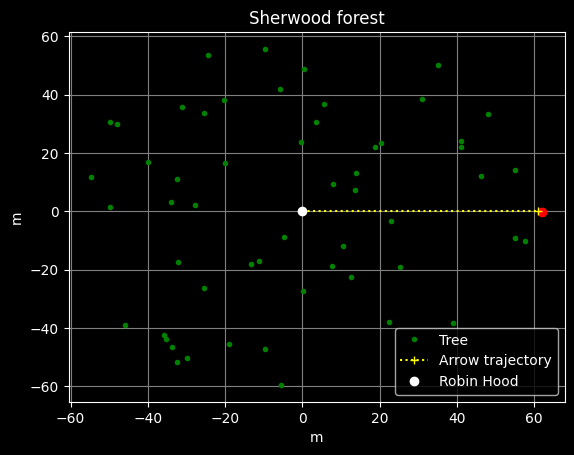

In [ ]:
plt.style.use('dark_background')
plt.plot(X,Y, '.g', label='Tree')
plt.plot(x,y, 'or')
plt.plot((0,d), (0,0), ':+', color = 'yellow', label='Arrow trajectory')
plt.plot(0,0, 'ow', label='Robin Hood')
plt.title('Proceso de Poisson Bivariado')
plt.title('Sherwood forest')
plt.xlabel('m')
plt.ylabel('m')
plt.grid(color='gray')
plt.legend()

plt.savefig('Cuarta_graf')
plt.show()

5. Ya que tenemos la simulación de un tiro, solo queda repetir los tiros varias veces para poder observar el comportamiento del proceso gracias al método de Monte Carlo. De manera que podamos llegar al estado estable de la simulación. Para ello es que usaremos la siguiente función.

In [ ]:
@jit(nopython = True)
def experimento(ρ, r=1, n = 10**4):
  l = []
  for i in range(n):
    _, _, d = bosque_flecha(ρ,r)
    l.append(d)
  return l

Se establecen lo parámetros de entrada de la función.

In [ ]:
densidad = 0.005
r = 1
n = 10**3

Se ejecuta la función y se encuentra un intervalo de confianza para el valor esperado de la distancia recorrida por la flecha hasta el impacto.

In [ ]:
l = experimento(densidad, r, n)

In [ ]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(n)}, {m + z*ds/np.sqrt(n)}]')

El intervalo de confianza del 95% es [90.28583210537285, 102.85894266318117]


6. Además, para poder visualizar de mejor manera los resultados del Monte Carlo, se presenta la siguiente gráfica del comportamiento de la simulación para ilustrar el estado transitorio y el estado estable de la simulación conforme el transcurso de las iteraciones.

In [ ]:
@jit(nopython = True)
def graf(l, p=1):
  ls = []
  for i in range(1,n):
    a = np.array(l[:i:p])
    ls.append(a.mean())

  return ls

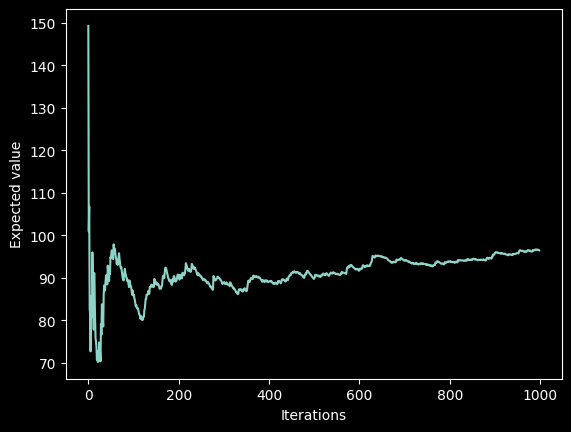

In [ ]:
ls = graf(l)

plt.plot(ls)
plt.xlabel('Iterations')
plt.ylabel('Expected value')
plt.savefig('Quinta_graf')
plt.show()

7. Finalmente, repetimos el experimento varias veces para encontrar la media de medias muestrales, la cual será el valor más aproximado a la distancia media que recorrerá la flecha hasta chocar con un árbol. En adición a esto se tiene un intervalo de confianza del 95%.

In [ ]:
@jit(nopython = True)
def rep(ρ, r, n = 10**3, n_rep = 10**2):
  l = []
  for i in range(n_rep):
    d = experimento(ρ, r, n)
    D = np.array(d)
    l.append(D.mean())
  return l

In [ ]:

nr = 10**3
l = rep(densidad, r, 400, nr)

In [ ]:
m = np.mean(l)
ds = np.std(l, ddof=1)
z = norm.ppf(0.975)
print(f'El intervalo de confianza del 95% es [{m - z*ds/np.sqrt(nr)}, {m + z*ds/np.sqrt(nr)}]')
print(m)

El intervalo de confianza del 95% es [98.78752625065849, 99.39745535785468]
99.09249080425658
